In [12]:
!pwd

/shared-docker/OpenEnv/src/envs/cartpole_env/server


In [1]:
import httpx, matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time, numpy as np
from PIL import Image
from io import BytesIO

from unsloth import FastLanguageModel
import torch
from peft import PeftModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/workspace/unsloth_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import torch

In [7]:
BASE_ID = "unsloth/Llama-3.2-3B-Instruct"
max_seq_length = 768
b,_ = FastLanguageModel.from_pretrained(
    model_name = BASE_ID,
    load_in_4bit = True,
    max_seq_length = max_seq_length,
    )
model_policy = PeftModel.from_pretrained(b, "/shared-docker/adapters/cartpole-lora-grpo").eval()

Unsloth: AMD currently is not stable with 4bit bitsandbytes. Disabling for now.
==((====))==  Unsloth 2025.10.9: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    AMD Radeon Graphics. Num GPUs = 1. Max memory: 191.688 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+rocm6.4. ROCm Toolkit: 6.4.43482-0f2d60242. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100% 2/2 [00:02<00:00,  1.17s/it]


In [9]:
from transformers import AutoTokenizer
import os

BASE_ID = "meta-llama/Llama-3.2-3B-Instruct"
ADAPTER_DIR = "/shared-docker/adapters/cartpole-lora-grpo"

def load_tokenizer(adapter_dir, base_id):
    # If tokenizer files were saved with the adapter dir, prefer them
    has_tok = os.path.exists(os.path.join(adapter_dir, "tokenizer_config.json"))
    tok = AutoTokenizer.from_pretrained(adapter_dir if has_tok else base_id, use_fast=True)
    # Ensure pad token is set (common for Llama)
    if tok.pad_token_id is None and tok.eos_token_id is not None:
        tok.pad_token = tok.eos_token
    return tok

tokenizer = load_tokenizer(ADAPTER_DIR, BASE_ID)

In [5]:
import requests
import time
time.sleep(5) # Wait 5 seconds for OpenEnv to start!
from envs.cartpole_env import CartPoleEnv
import httpx

# Same shape as: OpenSpielEnv(base_url=..., request_timeout_s=...)
base_url = "http://localhost:8020"
request_timeout_s = 1000  # seconds

openenv_process = CartPoleEnv(
    base_url=base_url,
    timeout=httpx.Timeout(connect=5.0, read=request_timeout_s, write=request_timeout_s, pool=30.0),
)

# quick smoke test
info = openenv_process.info()
print("CartPole info:", info)
SYSTEM = 'You are CartPoleMan. Return ONLY {"action": 0} or {"action": 1}.'
def build_prompt(obs_text):
    return (f"[ENV] CartPole-v1\nState: {obs_text}\n"
            f"Rules: 0=left, 1=right. Keep pole upright.\n"
            'Return ONLY: {"action": <0|1>}')

def obs_to_text(obs):
    x, dx, ang, dang = obs.values if hasattr(obs, "values") else obs  # supports pydantic or raw list
    return f"x={x:.3f}, dx={dx:.3f}, ang={ang:.3f}, dang={dang:.3f}"

# --- your trained policy decode (replace with your code) ---
def act_trained(model, tokenizer, system_msg, build_prompt, obs_to_text, obs):
    ids = tokenizer(f"<s>[INST]{system_msg}\n{build_prompt(obs_to_text(obs))}[/INST]",
                    return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**ids, max_new_tokens=16, do_sample=False,
                             temperature=0.0, pad_token_id=tokenizer.eos_token_id)
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    # parse_action should return 0 or 1
    return parse_action(text, default=0)

import re, json
def parse_action(text, default=None):
    # Try strict JSON first
    try:
        s, e = text.find("{"), text.rfind("}")+1
        if s != -1 and e != -1:
            obj = json.loads(text[s:e])
            a = int(obj.get("action"))
            if a in (0,1): return a
    except Exception:
        pass
    # Fallback: first 0/1 digit seen
    m = re.search(r"\b([01])\b", text)
    if m: return int(m.group(1))
    return default


INFO:httpx: HTTP Request: GET http://localhost:8020/info "HTTP/1.1 200 OK"


CartPole info: {'id': 'CartPole-v1', 'observation_space': {'shape': [4], 'dtype': 'float32'}, 'action_space': {'type': 'discrete', 'n': 2}, 'max_episode_steps': 500}


In [19]:


def get_frame():
    r = client.get(f"{BASE}/render")
    if r.status_code != 200: return None
    return np.array(Image.open(BytesIO(r.content)))

# rollout using your OpenEnv client for steps
s = openenv_process.reset()
obs = s.observation.values if hasattr(s.observation, "values") else s.observation
done = False; total = 0.0

plt.figure()
while not done:
    a = act_trained(model_policy, tokenizer, SYSTEM, build_prompt, obs_to_text, obs)
    st = openenv_process.step(int(a))
    total += float(st.reward)
    obs = st.observation.values if hasattr(st.observation, "values") else st.observation
    done = bool(st.done)

    frame = get_frame()
    if frame is not None:
        clear_output(wait=True)
        plt.imshow(frame); plt.axis('off'); display(plt.gcf())
    time.sleep(0.02)  # throttle
plt.close()
print("Return:", total)

INFO:httpx: HTTP Request: GET http://localhost:8020/info "HTTP/1.1 200 OK"
INFO:httpx: HTTP Request: POST http://localhost:8020/reset "HTTP/1.1 200 OK"


CartPole info: {'id': 'CartPole-v1', 'observation_space': {'shape': [4], 'dtype': 'float32'}, 'action_space': {'type': 'discrete', 'n': 2}, 'max_episode_steps': 500}


INFO:httpx: HTTP Request: POST http://localhost:8020/step "HTTP/1.1 200 OK"
INFO:httpx: HTTP Request: GET http://localhost:8020/render "HTTP/1.1 500 Internal Server Error"
INFO:httpx: HTTP Request: POST http://localhost:8020/step "HTTP/1.1 200 OK"
INFO:httpx: HTTP Request: GET http://localhost:8020/render "HTTP/1.1 500 Internal Server Error"
INFO:httpx: HTTP Request: POST http://localhost:8020/step "HTTP/1.1 200 OK"
INFO:httpx: HTTP Request: GET http://localhost:8020/render "HTTP/1.1 500 Internal Server Error"
INFO:httpx: HTTP Request: POST http://localhost:8020/step "HTTP/1.1 200 OK"
INFO:httpx: HTTP Request: GET http://localhost:8020/render "HTTP/1.1 500 Internal Server Error"
INFO:httpx: HTTP Request: POST http://localhost:8020/step "HTTP/1.1 200 OK"
INFO:httpx: HTTP Request: GET http://localhost:8020/render "HTTP/1.1 500 Internal Server Error"
INFO:httpx: HTTP Request: POST http://localhost:8020/step "HTTP/1.1 200 OK"
INFO:httpx: HTTP Request: GET http://localhost:8020/render "HTTP

Return: 9.0


error: XDG_RUNTIME_DIR not set in the environment.
INFO:matplotlib.animation: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Return: 10.0


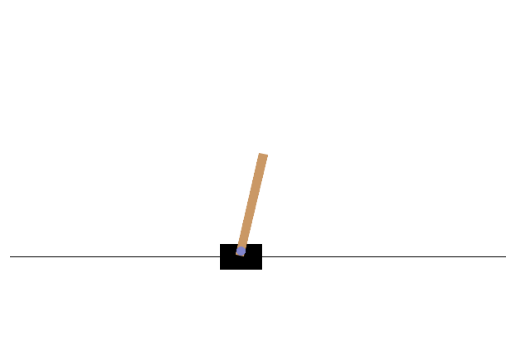

In [11]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

env = gym.make("CartPole-v1", render_mode="rgb_array")  # returns frames
obs, _ = env.reset(seed=123)
frames, rewards = [], []
done = False; total = 0.0

while not done:
    a = act_trained(model_policy, tokenizer, SYSTEM, build_prompt, obs_to_text, obs)
    obs, r, terminated, truncated, _ = env.step(int(a))
    total += r; done = terminated or truncated
    frames.append(env.render())  # ndarray (H,W,3)

env.close()
print("Return:", total)

# Matplotlib animation
fig = plt.figure()
im = plt.imshow(frames[0]); plt.axis('off')

def update(i):
    im.set_array(frames[i]); return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=10, blit=True)
HTML(ani.to_jshtml())  # inline playback

In [20]:
import gymnasium as gym
import numpy as np

# --- toy strategy (replace with your compiled/generated function) ---
def cartpole_strategy1(state):
    # state: [x, dx, angle, dangle]
    x, dx, ang, dang = state
    score = ang + 0.1 * dang
    return 1 if score > 0.0 else 0

def cartpole_strategy(state):
    # push toward angle sign (very simple)
    x, dx, ang, dang = state
    return 1 if ang > 0 else 0
    
def run_gym_cartpole(strategy_fn, episodes=3, seed=None, render_mode=None):
    """
    render_mode: None | "human" | "rgb_array"
    """
    env = gym.make("CartPole-v1", render_mode=render_mode)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=200)
    ep_returns, ep_lengths = [], []

    for ep in range(episodes):
        obs, _ = env.reset(seed=(None if seed is None else int(seed) + ep))
        print(obs)
        done = False
        total = 0.0
        steps = 0

        while not done:
            state = [float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])]
            a = int(strategy_fn(state))
            a = 0 if a <= 0 else 1  # clamp to {0,1}

            obs, r, terminated, truncated, _ = env.step(a)
            print(obs)
            total += float(r)
            steps += 1
            done = terminated or truncated

            if render_mode == "human":
                env.render()  # window updates automatically

        ep_returns.append(total)
        ep_lengths.append(steps)

    env.close()
    return ep_returns, ep_lengths

rets, lens = run_gym_cartpole(cartpole_strategy, episodes=5, seed=123, render_mode=None)
print("Episode returns:", rets)
print("Episode lengths:", lens)

[ 0.01823519 -0.0446179  -0.02796401 -0.03156282]
[ 0.01734283 -0.23932791 -0.02859527  0.25216764]
[ 0.01255627 -0.43403012 -0.02355192  0.5356957 ]
[ 0.00387567 -0.6288131  -0.012838    0.8208655 ]
[-0.00870059 -0.82375705  0.00357931  1.1094831 ]
[-0.02517574 -0.6286823   0.02576897  0.81792516]
[-0.03774938 -0.4339224   0.04212748  0.5334575 ]
[-0.04642783 -0.23941746  0.05279662  0.2543408 ]
[-0.05121618 -0.04508755  0.05788344 -0.02123289]
[-0.05211793  0.14915858  0.05745878 -0.29510587]
[-0.04913476  0.3434163   0.05155667 -0.569128  ]
[-0.04226643  0.5377787   0.0401741  -0.84513324]
[-0.03151086  0.73233014  0.02327144 -1.1249169 ]
[-1.6864257e-02  9.2713946e-01  7.7310286e-04 -1.4102106e+00]
[ 1.6785330e-03  1.1222517e+00 -2.7431110e-02 -1.7026517e+00]
[ 0.02412357  0.9274562  -0.06148414 -1.418632  ]
[ 0.04267269  0.73314685 -0.08985679 -1.1457837 ]
[ 0.05733563  0.5393059  -0.11277246 -0.8825777 ]
[ 0.06812175  0.34588134 -0.13042401 -0.6273686 ]
[ 0.07503937  0.15279774 -

In [ ]:
1
try strategy
1
observation=CartPoleObservation(values=[0.03275524079799652, 0.2340925931930542, 0.0007869747350923717, -0.31777694821357727]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.03743709251284599, 0.4292033314704895, -0.0055685644038021564, -0.6102116107940674]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.04602115973830223, 0.6244027018547058, -0.017772795632481575, -0.9046432375907898]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.058509211987257004, 0.8197607398033142, -0.0358656607568264, -1.2028590440750122]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.0749044269323349, 1.0153275728225708, -0.05992284044623375, -1.5065628290176392]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.0952109843492508, 1.2111228704452515, -0.09005409479141235, -1.8173354864120483]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.1194334402680397, 1.4071235656738281, -0.12640081346035004, -2.136585235595703]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.14757591485977173, 1.6032495498657227, -0.1691325157880783, -2.4654901027679443]) reward=1.0 done=False info={}
try strategy
1
observation=CartPoleObservation(values=[0.03242415934801102, -0.028623703867197037, 0.024146705865859985, 0.012994020245969296]) reward=1.0 done=True info={}
Toy strategy survived steps: 9